In [14]:
from problem_formulation import get_model_for_problem_formulation

import pickle

model, _ = get_model_for_problem_formulation(3)

In [15]:
from ema_workbench.util import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate 0': 3.5, 'discount rate 1': 3.5,
                    'discount rate 2': 3.5,
                    'ID flood wave shape': 4}
scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})
        
from ema_workbench import Scenario

ref_scenario = Scenario('reference', **scen1)

In [16]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

convergence_metrics = [EpsilonProgress()]

epsilon = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]   
 
nfe = 100 # 200 proof of principle only, way to low for actual use

from ema_workbench import MultiprocessingEvaluator

use_pickle1 = False
if use_pickle1:
    with open('data/MORDM_results1.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
        print(results)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario)
        #print(results,convergence)
        # Save results in Pickle file
        #with open("data/MORDM_results1.pickle","wb") as filehandler:
        #    pickle.dump(results,convergence,filehandler)

[MainProcess/INFO] pool started with 16 workers
100%|████████████████████████████████████████| 100/100 [00:06<00:00, 15.47it/s]
[MainProcess/INFO] optimization completed, found 65 solutions
[MainProcess/INFO] terminating pool


In [17]:
outcomes = results.loc[:, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
                           'A.2_Expected Number of Deaths','A.3 Total Costs','A.3_Expected Number of Deaths',
                           'A.4 Total Costs','A.4_Expected Number of Deaths','A.5 Total Costs',
                           'A.5_Expected Number of Deaths','RfR Total Costs','Expected Evacuation Costs']]

C:\Users\cwouw\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


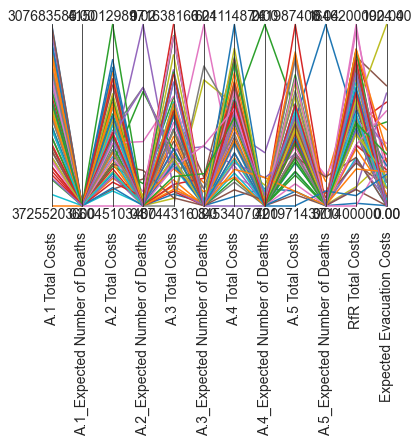

In [18]:
from ema_workbench.analysis import parcoords

import matplotlib.pyplot as plt

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.show()

In [19]:
print(results['A.1 Total Costs'].describe())
print(results['A.1_Expected Number of Deaths'].describe())
print(results['A.2 Total Costs'].describe())
print(results['A.2_Expected Number of Deaths'].describe())
print(results['A.3 Total Costs'].describe())
print(results['A.3_Expected Number of Deaths'].describe())
print(results['A.4 Total Costs'].describe())
print(results['A.4_Expected Number of Deaths'].describe())
print(results['A.5 Total Costs'].describe())
print(results['A.5_Expected Number of Deaths'].describe())
print(results['RfR Total Costs'].describe())
print(results['Expected Evacuation Costs'].describe())

count    6.500000e+01
mean     1.833329e+08
std      6.734948e+07
min      3.725520e+07
25%      1.266825e+08
50%      1.886001e+08
75%      2.298433e+08
max      3.076836e+08
Name: A.1 Total Costs, dtype: float64
count    65.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: A.1_Expected Number of Deaths, dtype: float64
count    6.500000e+01
mean     2.060631e+08
std      6.959200e+07
min      6.604510e+07
25%      1.568527e+08
50%      2.008058e+08
75%      2.426500e+08
max      4.150130e+08
Name: A.2 Total Costs, dtype: float64
count    65.000000
mean      0.000981
std       0.002835
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000346
max       0.015284
Name: A.2_Expected Number of Deaths, dtype: float64
count    6.500000e+01
mean     1.010705e+08
std      3.018625e+07
min      4.874432e+07
25%      7.751737e+07
50%      1.008259e+08
75%      1.177733e+08
max      1.716382e+08
Name: A.3 Total Costs, dtype

In [20]:
from ema_workbench import ScalarOutcome
model.outcomes = [ScalarOutcome('A.1 Total Costs', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('A.1_Expected Number of Deaths', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('A.2 Total Costs', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('A.2_Expected Number of Deaths', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('A.3 Total Costs', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('A.3_Expected Number of Deaths', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('A.4 Total Costs', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('A.4_Expected Number of Deaths', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('A.5 Total Costs', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('A.5_Expected Number of Deaths', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1)),
                       ScalarOutcome('RfR Total Costs', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

AttributeError: 'DataFrame' object has no attribute 'hypervolume'

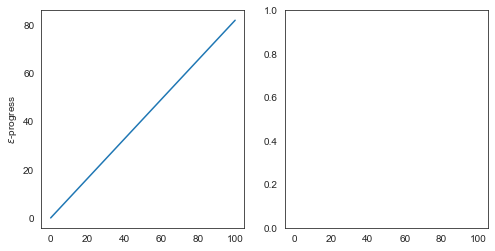

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()